# Things that don't make sense in the distribution of ELG targets
### This notebook is meant to explain what does not make sense in the DESI ELG target distribution and leave room for the solutions.
### Ideally, we would find the explanations before targeting is finalized, and this might help fix some issues before we start amassing the full ELG survey

#### import all needed python here

In [3]:
import fitsio
import numpy as np
#from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap
import astropy.io.fits as fits
import glob
import os
import healpy as hp
from matplotlib import pyplot as plt

#### The following imports all of the data generated elsewhere. This includes the DR8 versions of the ELG targets, the randoms, the pixelized maps of conditions, the depth based MC efficiency prediction...

In [11]:
#ELGs were saved here
elgf = os.getenv('SCRATCH')+'/ELGtargetinfo.fits'
felg = fitsio.read(elgf)
lelg = len(felg)
print('there are '+str(lelg)+ ' elg targets')

there are 47256516 elg targets


In [12]:
#full random file is available, easy to read some limited number; take 1.5x ELG to start with

rall = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',rows=np.arange(int(1.5*lelg))
                  )
rall_header = fitsio.read_header('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',ext=1)

In [13]:
#cut randoms to ELG footprint
keep = (rall['NOBS_G']>0) & (rall['NOBS_R']>0) & (rall['NOBS_Z']>0)
print(len(rall[keep]))
elgbits = [1,5,6,7,11,12,13]
keepelg = keep
for bit in elgbits:
    keepelg &= ((rall['MASKBITS'] & 2**bit)==0)
print(len(rall[keepelg]))
relg = rall[keepelg]

67762950
64567641


In [16]:
#Some information is in pixelized map
#get nside and nest from header
pixfn      = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
hdr        = fits.getheader(pixfn,1)
nside,nest = hdr['HPXNSIDE'],hdr['HPXNEST']
print(fits.open(pixfn)[1].columns.names)
hpq = fitsio.read(pixfn)

['HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'LRG_1PASS', 'LRG_2PASS', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY']


In [38]:
#get MC efficiency map
mcf = fitsio.read(os.getenv('SCRATCH')+'/ELGMCeffHSCHP.fits')
mmc = np.mean(mcf['EFF'])
mcl = np.zeros(12*nside*nside)
for i in range(0,len(mcf)):
    pix = mcf['HPXPIXEL'][i]
    mcl[pix] = mcf['EFF'][i]/mmc

In [14]:
#for healpix coordinates
def radec2thphi(ra,dec):
    return (-dec+90.)*np.pi/180.,ra*np.pi/180.

In [17]:
# put ELGs them into healpix
dth,dphi = radec2thphi(felg['RA'],felg['DEC'])
dpix = hp.ang2pix(nside,dth,dphi,nest)
dallpix = np.zeros(12*nside*nside)
for pix in dpix:
    dallpix[pix] += 1.

In [18]:
#put randoms into healpix
rth,rphi = radec2thphi(relg['RA'],relg['DEC'])
rpix = hp.ang2pix(nside,rth,rphi,nest=nest)
rallpix = np.zeros(12*nside*nside)
for pix in rpix:
    rallpix[pix] += 1.

#### First, to start with something that makes some sense, let's plot the density of ELGs and compare it to the MC prediction

In [24]:
#let's take a look at the density
mg = len(relg)/len(felg)
print(mg,sum(rallpix)/sum(dallpix))
wp = rallpix > 0
pixls = []
for i in range(0,len(rallpix)):
    if rallpix[i] > 0:
        pixls.append(i)
pixls = np.array(pixls).astype(int)        
th,phi = hp.pix2ang(nside,pixls,nest=nest)
od = dallpix[wp]/rallpix[wp]*mg
def thphi2radec(theta,phi):
    return 180./np.pi*phi,-(180./np.pi*theta-90)
ra,dec = thphi2radec(th,phi)

1.3663224982561135 1.3663224982561135


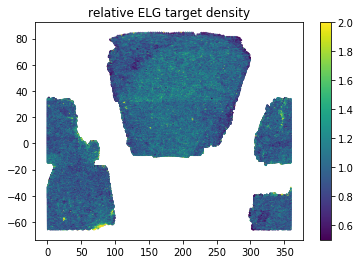

In [26]:
plt.scatter(ra,dec,c=od,vmax=2,vmin=.5,s=.1)
plt.colorbar()
plt.title('relative ELG target density')
plt.show()

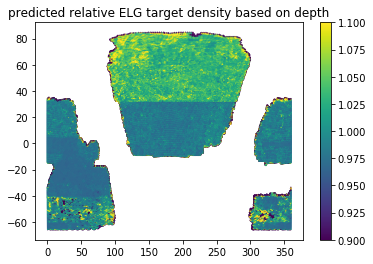

In [31]:
plt.scatter(ra,dec,c=mcl[wp],vmax=1.1,vmin=.9,s=.1)
plt.colorbar()
plt.title('predicted relative ELG target density based on depth')
plt.show()

The depth-based MC **does** predict we should be able to see the DES footprint and the deliniation between BASS/MzLS (bmzls) and DECaLS.
However, note that it predicts the **opposite** of what is seen in the high declination regions of bmzls.

### Assign quantities to data/randoms
While healpix is nice, we can avoid some pixelization effects by assigning quantities directly to the data/randoms. In some cases (stellar density), the pixelization remains, but in most it does not. In particular, we assign the different MC predictions for the different DECaLS/bmzls selections

In [39]:
grids = np.loadtxt(os.getenv('SCRATCH')+'/ELGeffgridsouth.dat').transpose()
#grids[3] = grids[3]
gridn = np.loadtxt(os.getenv('SCRATCH')+'/ELGeffgridnorth.dat').transpose()
#print(np.mean(gridn[3]))
#gridn[3] = gridn[3]/np.mean(gridn[3])
def interpeff(gsig,rsig,zsig,south=True):
    md = 0
    xg = 0.15
    #if gsig > xg:
    #    gsig = .99*xg
    xr = 0.15
    #if rsig > xr:
    #    rsig = 0.99*xr
    xz = 0.4
    #if zsig > xz:
    #    zsig = 0.99*xz
    ngp = 30
    if south:
        grid = grids
    else:
        grid = gridn
    i = (ngp*gsig/(xg-md)).astype(int)
    j = (ngp*rsig/(xr-md)).astype(int)
    k = (ngp*zsig/(xz-md)).astype(int)
    ind = (i*ngp**2.+j*ngp+k).astype(int)
    #print(i,j,k,ind)
    #print(grid[0][ind],grid[1][ind],grid[2][ind])
    #print(grid[0][ind-1],grid[1][ind-1],grid[2][ind-1])
    #print(grid[0][ind+1],grid[1][ind+1],grid[2][ind+1])
    return grid[3][ind]


In [40]:
#Get depth values that match those used for efficiency grids
depth_keyword="PSFDEPTH"
R_G=3.214 # http://legacysurvey.org/dr8/catalogs/#galactic-extinction-coefficients
R_R=2.165
R_Z=1.211

gsigmad=1./np.sqrt(felg[depth_keyword+"_G"])
rsigmad=1./np.sqrt(felg[depth_keyword+"_R"])
zsigmad=1./np.sqrt(felg[depth_keyword+"_Z"])
gsig = gsigmad*10**(0.4*R_G*felg["EBV"])
w = gsig >= 0.15
gsig[w] = 0.99*0.15
rsig = rsigmad*10**(0.4*R_R*felg["EBV"])
w = rsig >= 0.15
rsig[w] = 0.99*0.15
zsig = zsigmad*10**(0.4*R_Z*felg["EBV"])
w = zsig >= 0.4
zsig[w] = 0.99*0.4


/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [41]:
print(min(gsig),max(gsig))
effsouthl = interpeff(gsig,rsig,zsig,south=True)

0.011088011 0.14999883


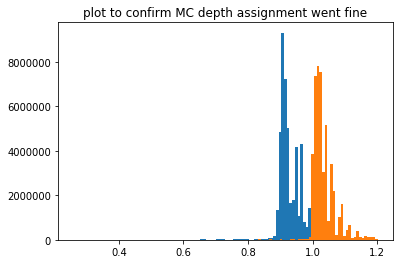

In [42]:
effnorthl = interpeff(gsig,rsig,zsig,south=False)
plt.hist(effnorthl,bins=100)
plt.hist(effsouthl,bins=100)
plt.title('plot to confirm MC depth assignment went fine')
plt.show()

#### assign stellar densities to data/random

In [43]:
stardensg = np.zeros(len(felg))
print(len(felg),len(dpix))
for i in range(0,len(dpix)):
    #if i%1000000==0 : print(i)
    pix = dpix[i]
    stardensg[i] = hpq['STARDENS'][pix]

47256516 47256516


In [44]:
stardensr = np.zeros(len(relg))
print(len(relg),len(rpix))
for i in range(0,len(rpix)):
    #if i%1000000==0 : print(i)
    pix = rpix[i]
    stardensr[i] = hpq['STARDENS'][pix]    

64567641 64567641


### Divide into three regions: DECaLS SGC, DECaLS NGC, bmzls

In [45]:
#let's define split into bmzls, DECaLS North, DECaLS South (Anand has tools to make distinct DES region as well)
#one function to do directly, the other just for the indices

print(np.unique(felg['PHOTSYS']))
#bmzls = b'N' #if in desi environment
bmzls = 'N' #if in Python 3; why the difference? Maybe version of fitsio?

def splitcat(cat):
    NN = cat['PHOTSYS'] == bmzls
    d1 = (cat['PHOTSYS'] != bmzls) & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return cat[NN],cat[d1],cat[d2]

def splitcat_ind(cat):
    NN = cat['PHOTSYS'] == bmzls
    d1 = (cat['PHOTSYS'] != bmzls) & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return NN,d1,d2

['N' 'S']


In [46]:
#indices for split
dbml,ddnl,ddsl = splitcat_ind(felg)
rbml,rdnl,rdsl = splitcat_ind(relg)
print('number in bmzls, DECaLS N, DECaLS S')
print(len(felg[dbml]),len(felg[ddnl]),len(felg[ddsl]))

number in bmzls, DECaLS N, DECaLS S
12726178 14094848 13407623


### Plot density dependence on different quantities, comparing different regions

In [75]:
#function to make plot comparing results in three regions
def plotrel(hg1,hr1,hg2,hr2,hg3,hr3,title,quant):
    xl1 = []
    xl2 = []
    xl3 = []
    for i in range(0,len(hg1[0])):
        xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
        xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
        xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
    norm1 = sum(hg1[0])/sum(hr1[0])    
    plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
    #plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
    norm2 = sum(hg2[0])/sum(hr2[0])
    plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
    #plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
    norm3 = sum(hg3[0])/sum(hr3[0])
    plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
    #plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
    plt.ylim(.7,1.3)
    plt.xlabel(quant)
    plt.ylabel('relative density')
    plt.legend((['bmzls','DECaLS N','DECaLS S']))
    plt.plot(xl2,np.ones(len(xl2)),'k--')
    plt.title(title)
    plt.show()

#### Start with raw results

In [46]:
#g-band depth
#bmzls
hg1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-R_G*felg[dbml]['EBV']),range=(0,2000))
hr1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-R_G*relg[rbml]['EBV']),bins=hg1[1])
#decals N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-R_G*felg[ddnl]['EBV']),range=(0,3000))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-R_G*relg[rdnl]['EBV']),bins=hg2[1])
#decals S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-R_G*felg[ddsl]['EBV']))
hr3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-R_G*relg[rdsl]['EBV']),bins=hg3[1])

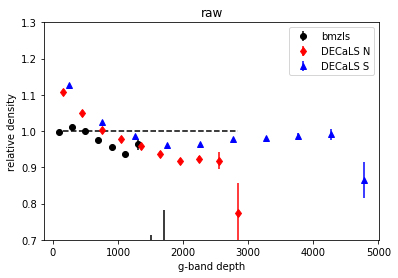

In [48]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'raw','g-band depth')

In [81]:
#r-band depth
#bmzls
hg1 = np.histogram(felg[dbml]['GALDEPTH_R']*np.exp(-R_R*felg[dbml]['EBV']),range=(0,500))
hr1 = np.histogram(relg[rbml]['GALDEPTH_R']*np.exp(-R_R*relg[rbml]['EBV']),bins=hg1[1])
#decals N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_R']*np.exp(-R_R*felg[ddnl]['EBV']),range=(0,1000))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_R']*np.exp(-R_R*relg[rdnl]['EBV']),bins=hg2[1])
#decals S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_R']*np.exp(-R_R*felg[ddsl]['EBV']),range=(0,1000))
hr3 = np.histogram(relg[rdsl]['GALDEPTH_R']*np.exp(-R_R*relg[rdsl]['EBV']),bins=hg3[1])

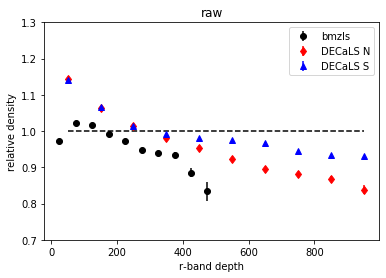

In [82]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'raw','r-band depth')

In [51]:
#z-band depth
#bmzls
hg1 = np.histogram(felg[dbml]['GALDEPTH_Z']*np.exp(-R_Z*felg[dbml]['EBV']))
hr1 = np.histogram(relg[rbml]['GALDEPTH_Z']*np.exp(-R_Z*relg[rbml]['EBV']),bins=hg1[1])
#decals N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_Z']*np.exp(-R_Z*felg[ddnl]['EBV']))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_Z']*np.exp(-R_Z*relg[rdnl]['EBV']),bins=hg2[1])
#decals S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_Z']*np.exp(-R_Z*felg[ddsl]['EBV']))
hr3 = np.histogram(relg[rdsl]['GALDEPTH_Z']*np.exp(-R_Z*relg[rdsl]['EBV']),bins=hg3[1])

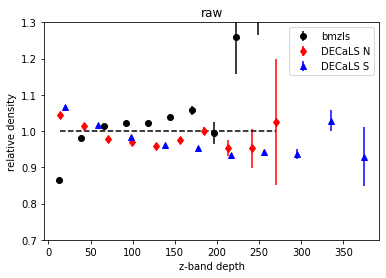

In [52]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'raw','z-band depth')

#### Now apply MC, with ^2 for DECaLS

In [56]:
#g-band depth
#bmzls
hg1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-R_G*felg[dbml]['EBV']),weights=1./effnorthl[dbml],range=(0,2000))
hr1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-R_G*relg[rbml]['EBV']),bins=hg1[1])
#decals N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-R_G*felg[ddnl]['EBV']),weights=1./effsouthl[ddnl]**2.,range=(0,3000))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-R_G*relg[rdnl]['EBV']),bins=hg2[1])
#decals S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-R_G*felg[ddsl]['EBV']),weights=1./effsouthl[ddsl]**2.)
hr3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-R_G*relg[rdsl]['EBV']),bins=hg3[1])

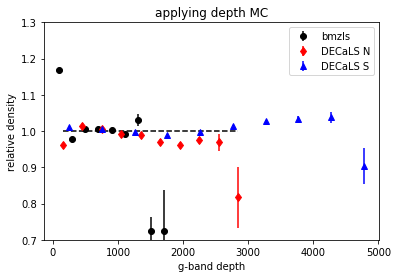

In [57]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'applying depth MC','g-band depth')

In [77]:
#r-band depth
#bmzls
hg1 = np.histogram(felg[dbml]['GALDEPTH_R']*np.exp(-R_R*felg[dbml]['EBV']),weights=1./effnorthl[dbml],range=(0,500))
hr1 = np.histogram(relg[rbml]['GALDEPTH_R']*np.exp(-R_R*relg[rbml]['EBV']),bins=hg1[1])
#decals N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_R']*np.exp(-R_R*felg[ddnl]['EBV']),weights=1./effsouthl[ddnl]**2.,range=(0,1000))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_R']*np.exp(-R_R*relg[rdnl]['EBV']),bins=hg2[1])
#decals S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_R']*np.exp(-R_R*felg[ddsl]['EBV']),weights=1./effsouthl[ddsl]**2.,range=(0,1000))
hr3 = np.histogram(relg[rdsl]['GALDEPTH_R']*np.exp(-R_R*relg[rdsl]['EBV']),bins=hg3[1])

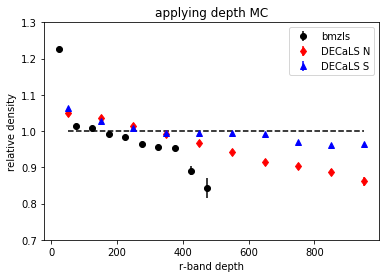

In [78]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'applying depth MC','r-band depth')

In [62]:
#z-band depth
#bmzls
hg1 = np.histogram(felg[dbml]['GALDEPTH_Z']*np.exp(-R_Z*felg[dbml]['EBV']),weights=1./effnorthl[dbml])
hr1 = np.histogram(relg[rbml]['GALDEPTH_Z']*np.exp(-R_Z*relg[rbml]['EBV']),bins=hg1[1])
#decals N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_Z']*np.exp(-R_Z*felg[ddnl]['EBV']),weights=1./effsouthl[ddnl]**2.)
hr2 = np.histogram(relg[rdnl]['GALDEPTH_Z']*np.exp(-R_Z*relg[rdnl]['EBV']),bins=hg2[1])
#decals S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_Z']*np.exp(-R_Z*felg[ddsl]['EBV']),weights=1./effsouthl[ddsl]**2.)
hr3 = np.histogram(relg[rdsl]['GALDEPTH_Z']*np.exp(-R_Z*relg[rdsl]['EBV']),bins=hg3[1])

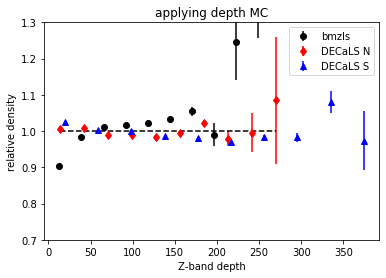

In [63]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'applying depth MC','z-band depth')

#### Big improvement for g-band, not much for r-band, and a little bit for z band
#### Now check stellar density relationship after MC and after approximate linear fit

In [65]:
#bmzls
slp = -0.2/4000.
b = 1.1
wsb = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(stardensg[dbml],weights=1./effnorthl[dbml],range=(0,5000))
hgn1 = np.histogram(stardensg[dbml],bins=hg1[1])
hr1 = np.histogram(stardensr[rbml],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
wsn = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(stardensg[ddnl],weights=1./effsouthl[ddnl]**2.,range=(0,5000))
hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(stardensr[rdnl],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(stardensg[ddsl],weights=1./effsouthl[ddsl]**2.,range=(0,5000))
hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(stardensr[rdsl],bins=hg3[1])

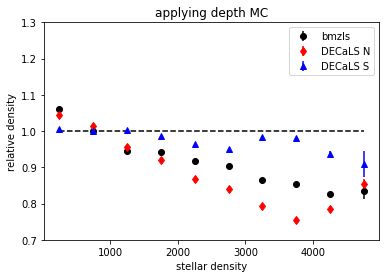

In [66]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'applying depth MC','stellar density')

## Question: Why is relationship with stellar density so different between DECaLS N and S?

In [67]:
#bmzls
slp = -0.2/4000.
b = 1.1
wsb = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(stardensg[dbml],weights=1./effnorthl[dbml]*wsb,range=(0,5000))
hgn1 = np.histogram(stardensg[dbml],bins=hg1[1])
hr1 = np.histogram(stardensr[rbml],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
wsn = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(stardensg[ddnl],weights=1./effsouthl[ddnl]**2.*wsn,range=(0,5000))
hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(stardensr[rdnl],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(stardensg[ddsl],weights=1./effsouthl[ddsl]**2.,range=(0,5000))
hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(stardensr[rdsl],bins=hg3[1])

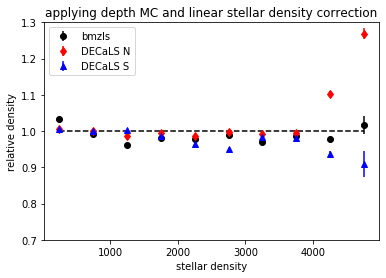

In [68]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'applying depth MC and linear stellar density correction','stellar density')

#### apply linear stellar density relationship to depth

In [69]:
#g-band depth
#bmzls
hg1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-R_G*felg[dbml]['EBV']),weights=1./effnorthl[dbml]*wsb,range=(0,2000))
hr1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-R_G*relg[rbml]['EBV']),bins=hg1[1])
#decals N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-R_G*felg[ddnl]['EBV']),weights=1./effsouthl[ddnl]**2.*wsn,range=(0,3000))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-R_G*relg[rdnl]['EBV']),bins=hg2[1])
#decals S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-R_G*felg[ddsl]['EBV']),weights=1./effsouthl[ddsl]**2.)
hr3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-R_G*relg[rdsl]['EBV']),bins=hg3[1])

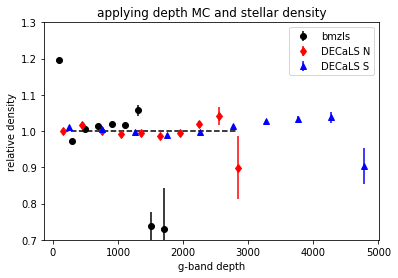

In [70]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'applying depth MC and stellar density','g-band depth')

In [75]:
#r-band depth
#bmzls
hg1 = np.histogram(felg[dbml]['GALDEPTH_R']*np.exp(-R_R*felg[dbml]['EBV']),weights=1./effnorthl[dbml]*wsb,range=(0,500))
hr1 = np.histogram(relg[rbml]['GALDEPTH_R']*np.exp(-R_R*relg[rbml]['EBV']),bins=hg1[1])
#decals N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_R']*np.exp(-R_R*felg[ddnl]['EBV']),weights=1./effsouthl[ddnl]**2.*wsn,range=(0,1000))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_R']*np.exp(-R_R*relg[rdnl]['EBV']),bins=hg2[1])
#decals S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_R']*np.exp(-R_R*felg[ddsl]['EBV']),weights=1./effsouthl[ddsl]**2.,range=(0,1000))
hr3 = np.histogram(relg[rdsl]['GALDEPTH_R']*np.exp(-R_R*relg[rdsl]['EBV']),bins=hg3[1])

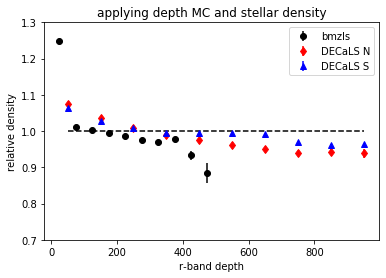

In [76]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'applying depth MC and stellar density','r-band depth')

In [73]:
#z-band depth
#bmzls
hg1 = np.histogram(felg[dbml]['GALDEPTH_Z']*np.exp(-R_Z*felg[dbml]['EBV']),weights=1./effnorthl[dbml]*wsb)
hr1 = np.histogram(relg[rbml]['GALDEPTH_Z']*np.exp(-R_Z*relg[rbml]['EBV']),bins=hg1[1])
#decals N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_Z']*np.exp(-R_Z*felg[ddnl]['EBV']),weights=1./effsouthl[ddnl]**2.*wsn)
hr2 = np.histogram(relg[rdnl]['GALDEPTH_Z']*np.exp(-R_Z*relg[rdnl]['EBV']),bins=hg2[1])
#decals S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_Z']*np.exp(-R_Z*felg[ddsl]['EBV']),weights=1./effsouthl[ddsl]**2.)
hr3 = np.histogram(relg[rdsl]['GALDEPTH_Z']*np.exp(-R_Z*relg[rdsl]['EBV']),bins=hg3[1])

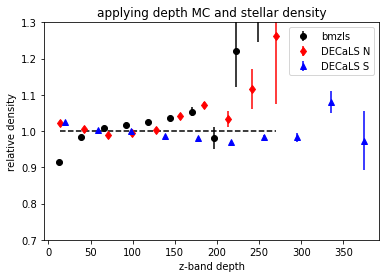

In [74]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'applying depth MC and stellar density','z-band depth')

## So, r-band depth relationship still significant, z-band not perfect

## Keeping MC and stellar density corrections, look at other quantities

In [83]:
#Galactic extinction
#bmzls
hg1 = np.histogram(felg[dbml]['EBV'],weights=1./1./effnorthl[dbml]*wsb,range=(0,0.15))
hr1 = np.histogram(relg[rbml]['EBV'],bins=hg1[1])
#DECaLS N
hg2 = np.histogram(felg[ddnl]['EBV'],weights=1./effsouthl[ddnl]**2.*wsn,range=(0,0.15))
hr2 = np.histogram(relg[rdnl]['EBV'],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(felg[ddsl]['EBV'],weights=1./effsouthl[ddsl]**2.,range=(0,0.15))
hr3 = np.histogram(relg[rdsl]['EBV'],bins=hg3[1])

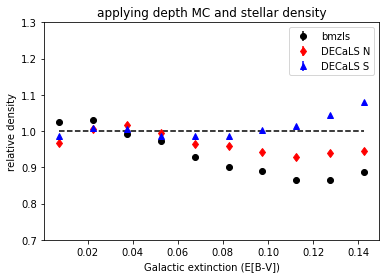

In [84]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'applying depth MC and stellar density','Galactic extinction (E[B-V])')

## Strong residual dependence on Galactic extinction for bmzls, why?

In [6]:

sweep = fitsio.read('/global/cscratch1/sd/rongpu/temp/dr8_sky_residual_south.fits')
sweepn = fitsio.read('/global/cscratch1/sd/rongpu/temp/dr8_sky_residual_north.fits')

In [4]:
sweep.dtype.names

('RA', 'DEC', 'MASKBITS', 'g_sky', 'r_sky', 'z_sky')

In [29]:
elgbits = [1,5,6,7,11,12,13]
keeps = np.ones(len(sweep)).astype(bool)
for bit in elgbits:
    keeps &= ((sweep['MASKBITS'] & 2**bit)==0)
print(len(sweep[keeps]))
sweepm = sweep[keeps]

22582680


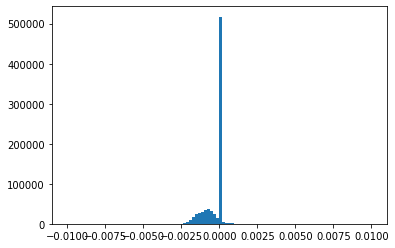

In [39]:
plt.hist(sallpixg,bins=100,range=(-0.01,0.01))
plt.show()

In [32]:
# put into healpix
sth,sphi = radec2thphi(sweepm['RA'],sweepm['DEC'])
spix = hp.ang2pix(nside,sth,sphi,nest)
sallpix = np.zeros(12*nside*nside)
sallpixg = np.zeros(12*nside*nside)
for i in range(0,len(spix)):
    pix = spix[i]
    sallpix[pix] += 1.
    sallpixg[pix] += sweepm[i]['g_sky']

In [54]:
sallpixr = np.zeros(12*nside*nside)
sallpixz = np.zeros(12*nside*nside)
for i in range(0,len(spix)):
    pix = spix[i]
    sallpixz[pix] += sweepm[i]['z_sky']
    sallpixr[pix] += sweepm[i]['r_sky']

In [55]:
w = sallpix > 0
sallpixr[w] = sallpixr[w]/sallpix[w]
w = sallpix > 0
sallpixz[w] = sallpixz[w]/sallpix[w]

In [34]:
w = sallpix > 0
sallpixg[w] = sallpixg[w]/sallpix[w]

In [56]:
gres_r = np.zeros(len(felg))
gres_z = np.zeros(len(felg))
print(len(felg),len(dpix))
for i in range(0,len(dpix)):
    if i%1000000==0 : print(i)
    pix = dpix[i]
    gres_r[i] = sallpixr[pix]
    gres_z[i] = sallpixz[pix]

In [58]:
rres_r = np.zeros(len(relg))
rres_z = np.zeros(len(relg))
print(len(relg),len(rpix))
for i in range(0,len(rpix)):
    #if i%1000000==0 : print(i)
    pix = rpix[i]
    rres_r[i] = sallpixr[pix] 
    rres_z[i] = sallpixz[pix]

64567641 64567641


In [40]:
gres_g = np.zeros(len(felg))
print(len(felg),len(dpix))
for i in range(0,len(dpix)):
    if i%1000000==0 : print(i)
    pix = dpix[i]
    gres_g[i] = sallpixg[pix]

47256516 47256516
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000


In [41]:
rres_g = np.zeros(len(relg))
print(len(relg),len(rpix))
for i in range(0,len(rpix)):
    #if i%1000000==0 : print(i)
    pix = rpix[i]
    rres_g[i] = sallpixg[pix]   

64567641 64567641


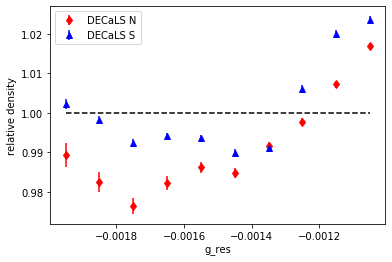

In [111]:
#DECaLS N
hg2 = np.histogram(gres_g[ddnl],range=(-.002,-.001))#,weights=1./effsouthl[ddnl]**2.,range=(0,5000))
#hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(rres_g[rdnl],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(gres_g[ddsl],range=(-.002,-.001))#,range=(-.1,.1))#,weights=1./effsouthl[ddsl]**2.,range=(0,5000))
#hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(rres_g[rdsl],bins=hg3[1])
#xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg2[0])):
    #xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
#norm1 = sum(hg1[0])/sum(hr1[0])    
#plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
#plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
#plt.ylim(.7,1.3)
plt.xlabel('g_res')
plt.ylabel('relative density')
plt.legend((['DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title(title)
plt.show()

In [51]:
w = gres_g < -0.0015

In [52]:
len(felg[w])

5460993

In [53]:
len(felg)

47256516

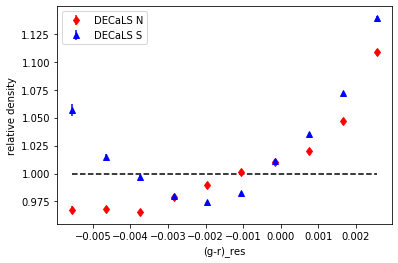

In [110]:
#DECaLS N
hg2 = np.histogram(gres_g[ddnl]+gres_r[ddnl]-gres_z[ddnl],range=(-.006,.003))#,weights=1./effsouthl[ddnl]**2.,range=(0,5000))
#hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(rres_g[rdnl]+rres_r[rdnl]-rres_z[rdnl],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(gres_g[ddsl]+gres_r[ddsl]-gres_z[ddsl],range=(-.006,.003))#,range=(-.1,.1))#,weights=1./effsouthl[ddsl]**2.,range=(0,5000))
#hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(rres_g[rdsl]+rres_r[rdsl]-rres_z[rdsl],bins=hg3[1])
#xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg2[0])):
    #xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
#norm1 = sum(hg1[0])/sum(hr1[0])    
#plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
#plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
#plt.ylim(.7,1.3)
plt.xlabel('(g-r)_res')
plt.ylabel('relative density')
plt.legend((['DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title(title)
plt.show()

In [69]:
xl2

[-0.00555,
 -0.00465,
 -0.00375,
 -0.00285,
 -0.0019499999999999997,
 -0.0010499999999999997,
 -0.00014999999999999953,
 0.0007500000000000007,
 0.0016500000000000009,
 0.0025500000000000006]

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


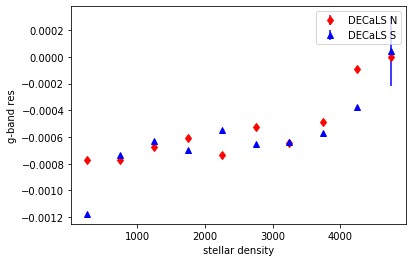

In [75]:
#DECaLS N
hg2 = np.histogram(stardensg[ddnl],weights=gres_g[ddnl],range=(0,5000))
#hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(stardensr[rdnl],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(stardensg[ddsl],weights=gres_g[ddsl],range=(0,5000))
#hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(stardensr[rdsl],bins=hg3[1])
#xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg2[0])):
    #xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
#norm1 = sum(hg1[0])/sum(hr1[0])    
#plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
#norm2 = sum(hg2[0])/sum(hr2[0])
norm2 = len(stardensg)/len(stardensr)
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
#norm3 = sum(hg3[0])/sum(hr3[0])
norm3 = norm2
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
#plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
#plt.ylim(.7,1.3)
plt.xlabel('stellar density')
plt.ylabel('g-band res')
plt.legend((['DECaLS N','DECaLS S']))
#plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title(title)
plt.show()

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


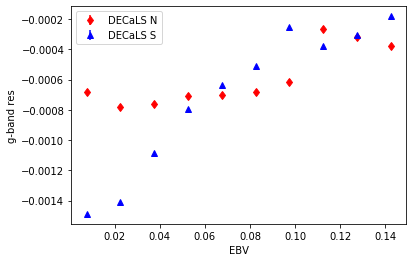

In [76]:
#DECaLS N
hg2 = np.histogram(felg[ddnl]['EBV'],weights=gres_g[ddnl],range=(0,0.15))
#hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['EBV'],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(felg[ddsl]['EBV'],weights=gres_g[ddsl],range=(0,.15000))
#hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['EBV'],bins=hg3[1])
#xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg2[0])):
    #xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
#norm1 = sum(hg1[0])/sum(hr1[0])    
#plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
#norm2 = sum(hg2[0])/sum(hr2[0])
norm2 = len(stardensg)/len(stardensr)
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
#norm3 = sum(hg3[0])/sum(hr3[0])
norm3 = norm2
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
#plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
#plt.ylim(.7,1.3)
plt.xlabel('EBV')
plt.ylabel('g-band res')
plt.legend((['DECaLS N','DECaLS S']))
#plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title(title)
plt.show()

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


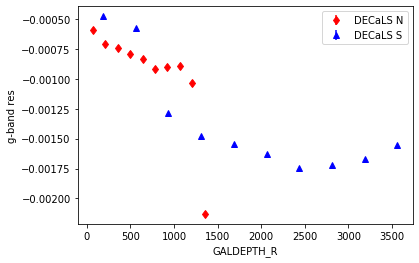

In [79]:
#DECaLS N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_R'],weights=gres_g[ddnl])#,range=(0,0.15))
#hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['GALDEPTH_R'],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_R'],weights=gres_g[ddsl])#,range=(0,.15000))
#hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['GALDEPTH_R'],bins=hg3[1])
#xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg2[0])):
    #xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
#norm1 = sum(hg1[0])/sum(hr1[0])    
#plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
#norm2 = sum(hg2[0])/sum(hr2[0])
norm2 = len(stardensg)/len(stardensr)
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
#norm3 = sum(hg3[0])/sum(hr3[0])
norm3 = norm2
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
#plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
#plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_R')
plt.ylabel('g-band res')
plt.legend((['DECaLS N','DECaLS S']))
#plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title(title)
plt.show()

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


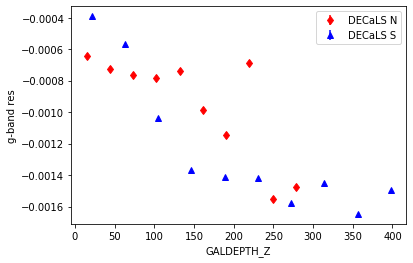

In [81]:
#DECaLS N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_Z'],weights=gres_g[ddnl])#,range=(0,0.15))
#hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['GALDEPTH_Z'],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_Z'],weights=gres_g[ddsl])#,range=(0,.15000))
#hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['GALDEPTH_Z'],bins=hg3[1])
#xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg2[0])):
    #xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
#norm1 = sum(hg1[0])/sum(hr1[0])    
#plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
#norm2 = sum(hg2[0])/sum(hr2[0])
norm2 = len(stardensg)/len(stardensr)
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
#norm3 = sum(hg3[0])/sum(hr3[0])
norm3 = norm2
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
#plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
#plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_Z')
plt.ylabel('g-band res')
plt.legend((['DECaLS N','DECaLS S']))
#plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title(title)
plt.show()

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


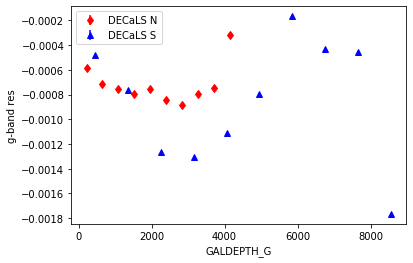

In [82]:
#DECaLS N
hg2 = np.histogram(felg[ddnl]['GALDEPTH_G'],weights=gres_g[ddnl])#,range=(0,0.15))
#hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['GALDEPTH_G'],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_G'],weights=gres_g[ddsl])#,range=(0,.15000))
#hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['GALDEPTH_G'],bins=hg3[1])
#xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg2[0])):
    #xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
#norm1 = sum(hg1[0])/sum(hr1[0])    
#plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
#norm2 = sum(hg2[0])/sum(hr2[0])
norm2 = len(stardensg)/len(stardensr)
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
#norm3 = sum(hg3[0])/sum(hr3[0])
norm3 = norm2
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
#plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
#plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_G')
plt.ylabel('g-band res')
plt.legend((['DECaLS N','DECaLS S']))
#plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title(title)
plt.show()

In [83]:
felg.dtype.names

('RA',
 'DEC',
 'BRICKNAME',
 'MORPHTYPE',
 'DCHISQ',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'EBV',
 'PHOTSYS',
 'TARGETID',
 'DESI_TARGET')

14094848
237329 325063
14094848
3809444 5297581
14094848
9113646 12233349
14094848
737930 930583
14094848
14094848
107904 108121
14094848


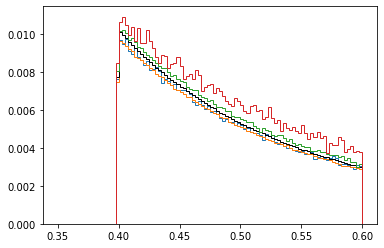

In [107]:
print(len(felg[ddnl]))
w = ddnl & (gres_g < -0.002)
wr = rdnl & (rres_g < -0.002)
nr = len(relg[wr])
ng = len(felg[w])
nl = np.ones(ng)/nr
print(ng,nr)
plt.hist(felg[w]['FLUX_G']/felg[w]['MW_TRANSMISSION_G'],weights=nl,bins=100,histtype='step',range=(.35,.6))
print(len(felg[ddnl]))
w = ddnl & (gres_g > -0.002) & (gres_g < -0.001)
wr = rdnl & (rres_g > -0.002) & (rres_g < -0.001)
nr = len(relg[wr])
ng = len(felg[w])
nl = np.ones(ng)/nr
print(ng,nr)
plt.hist(felg[w]['FLUX_G']/felg[w]['MW_TRANSMISSION_G'],weights=nl,bins=100,histtype='step',range=(.35,.6))
print(len(felg[ddnl]))
w = ddnl & (gres_g > -0.001) & (gres_g < 0.00)
wr = rdnl & (rres_g > -0.001) & (rres_g < 0.00)
nr = len(relg[wr])
ng = len(felg[w])
nl = np.ones(ng)/nr
print(ng,nr)
plt.hist(felg[w]['FLUX_G']/felg[w]['MW_TRANSMISSION_G'],weights=nl,bins=100,histtype='step',range=(.35,.6),color='k')
print(len(felg[ddnl]))
w = ddnl & (gres_g > 0.00) & (gres_g < 0.001)
wr = rdnl & (rres_g > 0.00) & (rres_g < 0.001)
nr = len(relg[wr])
ng = len(felg[w])
nl = np.ones(ng)/nr
print(ng,nr)
plt.hist(felg[w]['FLUX_G']/felg[w]['MW_TRANSMISSION_G'],weights=nl,bins=100,histtype='step',range=(.35,.6))
print(len(felg[ddnl]))
print(len(felg[ddnl]))
w = ddnl & (gres_g > 0.001)# & (gres_g < 0.001)
wr = rdnl & (rres_g > 0.001)# & (rres_g < 0.001)
nr = len(relg[wr])
ng = len(felg[w])
nl = np.ones(ng)/nr
print(ng,nr)
plt.hist(felg[w]['FLUX_G']/felg[w]['MW_TRANSMISSION_G'],weights=nl,bins=100,histtype='step',range=(.35,.6))
print(len(felg[ddnl]))

plt.show()

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


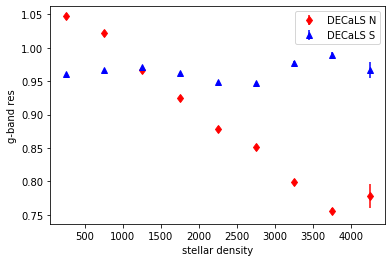

In [113]:
wg = ddnl & (gres_g < 0)
wr = rdnl & (rres_g < 0)
#DECaLS N
hg2 = np.histogram(stardensg[wg],range=(0,5000))
#hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(stardensr[wr],bins=hg2[1])

#DECaLS S
wg = ddsl & (gres_g < 0)
wr = rdsl & (rres_g < 0)
hg3 = np.histogram(stardensg[wg],range=(0,5000))
#hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(stardensr[wr],bins=hg2[1])
#xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg2[0])):
    #xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
#norm1 = sum(hg1[0])/sum(hr1[0])    
#plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
#norm2 = sum(hg2[0])/sum(hr2[0])
norm2 = len(stardensg)/len(stardensr)
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
#norm3 = sum(hg3[0])/sum(hr3[0])
norm3 = norm2
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
#plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
#plt.ylim(.7,1.3)
plt.xlabel('stellar density')
plt.ylabel('g-band res')
plt.legend((['DECaLS N','DECaLS S']))
#plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title(title)
plt.show()

In [1]:
import pandas as pd

In [5]:
smf = os.getenv('SCRATCH')+'/dr8_combined256.h5'

In [6]:
sm = pd.read_hdf(smf)

In [7]:
len(sm)

786432

In [9]:
sm['airmass_g_mean'][0]

nan

In [34]:
wp = rallpix > 0
pixls = []
for i in range(0,len(rallpix)):
    if rallpix[i] > 0:
        pixls.append(i)
pixls = np.array(pixls).astype(int)        
th,phi = hp.pix2ang(nside,pixls,nest=nest)
od = hp.reorder(sm['hits_g_total'],r2n=True)[wp]
def thphi2radec(theta,phi):
    return 180./np.pi*phi,-(180./np.pi*theta-90)
ra,dec = thphi2radec(th,phi)

In [24]:
sm.columns

Index(['airmass_g_mean', 'ccdskymag_g_mean', 'exptime_g_total', 'fwhm_g_mean',
       'hits_g_fracdet', 'hits_g_total', 'depth_g_total', 'mjd_g_min',
       'airmass_r_mean', 'ccdskymag_r_mean', 'exptime_r_total', 'fwhm_r_mean',
       'hits_r_fracdet', 'hits_r_total', 'depth_r_total', 'mjd_r_min',
       'airmass_z_mean', 'ccdskymag_z_mean', 'exptime_z_total', 'fwhm_z_mean',
       'hits_z_fracdet', 'hits_z_total', 'depth_z_total', 'mjd_z_min', 'nstar',
       'ebv', 'loghi'],
      dtype='object')

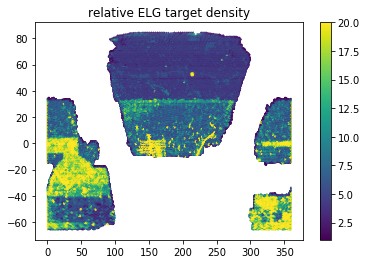

In [37]:
plt.scatter(ra,dec,c=od,s=.1,vmax=20)
plt.colorbar()
plt.title('relative ELG target density')
plt.show()

In [62]:
#wp &= hp.reorder(sm['hits_g_total'],r2n=True)*0 == 0
od = hp.reorder(sm['hits_g_total'],r2n=True)#[wp]
np.percentile(od, 99)

nan

In [63]:
wn = (od*0 != 0) & (rallpix > 0)

In [68]:
wg = np.isnan(od)
np.mean(od[~wg])
od[wn] = np.mean(od[~wg])
od[wn]

array([14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 14.629455, 14.629455,
       14.629455, 14.629455, 14.629455, 14.629455, 

In [73]:
def doplotmmap(name):
    od = hp.reorder(sm[name],r2n=True)
    wn = (od*0 != 0) & ((rallpix > 0) | (dallpix > 0))
    wg = np.isnan(od)
    print(len(od[wn]))
    od[wn] = np.mean(od[~wg])
    print(np.mean(od[~wg]))
    odg = np.zeros(len(felg))
    print(len(felg),len(dpix))
    for i in range(0,len(dpix)):
        #if i%1000000==0 : print(i)
        pix = dpix[i]
        odg[i] = od[pix]    
    print('gal done')
    odr = np.zeros(len(relg))
    
    for i in range(0,len(rpix)):
        #if i%1000000==0 : print(i)
        pix = rpix[i]
        odr[i] = od[pix]    
    print('ran done')
    #bmzls
    hg1 = np.histogram(odg[dbml],weights=1./effnorthl[dbml],range=(np.percentile(odg[dbml],2.5),np.percentile(odg[dbml],97.5)))
    hr1 = np.histogram(odr[rbml],bins=hg1[1])
    #DECaLS N

    hg2 = np.histogram(odg[ddnl],weights=1./effsouthl[ddnl]**2.,range=(np.percentile(odg[ddnl],2.5),np.percentile(odg[ddnl],97.5)))
    hr2 = np.histogram(odr[rdnl],bins=hg2[1])

    #DECaLS S
    hg3 = np.histogram(odg[ddsl],weights=1./effsouthl[ddsl]**2.,range=(np.percentile(odg[ddsl],2.5),np.percentile(odg[ddsl],97.5)))
    hr3 = np.histogram(odr[rdsl],bins=hg3[1])
    plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'with depth correction',name)

992
14.629454996806823
47256516 47256516
gal done
ran done


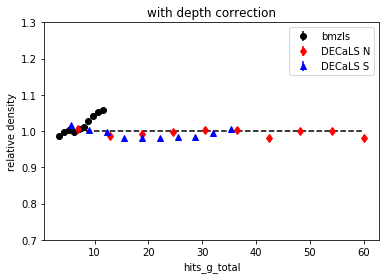

In [76]:
doplotmmap('hits_g_total')

992
1.3408565629045797
47256516 47256516
gal done
ran done


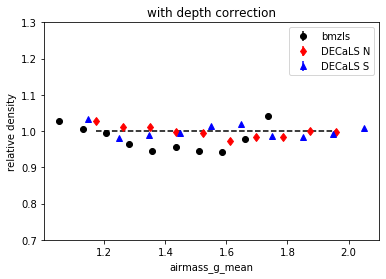

1118
26.43684443559328
47256516 47256516
gal done
ran done


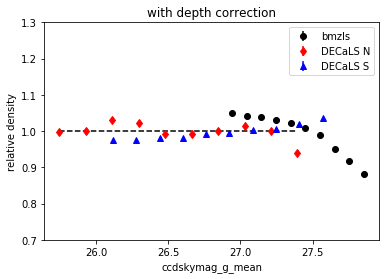

992
1814.8150981560948
47256516 47256516
gal done
ran done


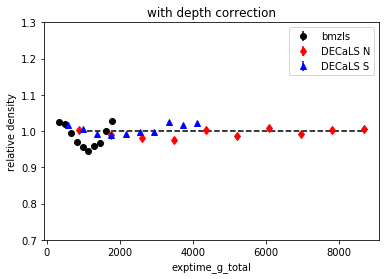

992
1.4293593620615017
47256516 47256516
gal done
ran done


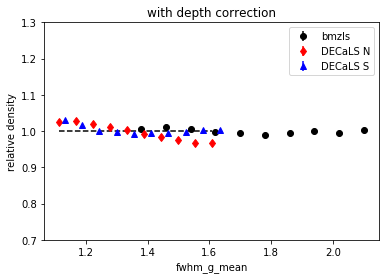

992
1.0
47256516 47256516
gal done
ran done


/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


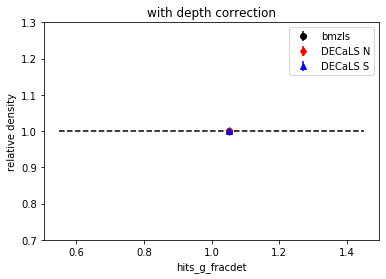

992
14.629454996806823
47256516 47256516
gal done
ran done


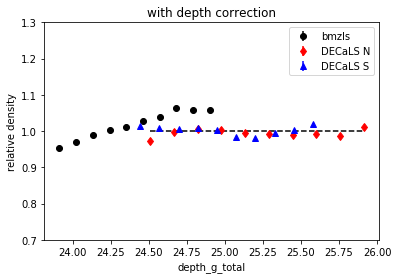

992
57437.56121851446
47256516 47256516
gal done
ran done


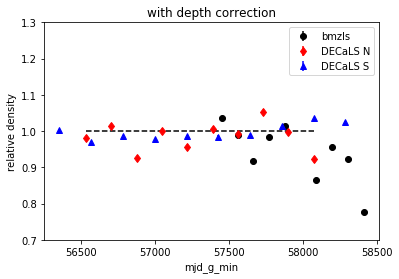

916
1.3428321561254157
47256516 47256516
gal done
ran done


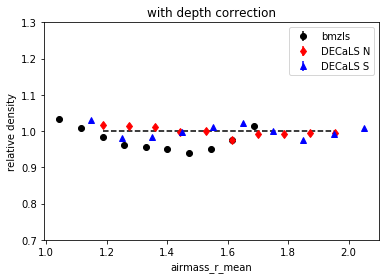

1030
25.06775107932448
47256516 47256516
gal done
ran done


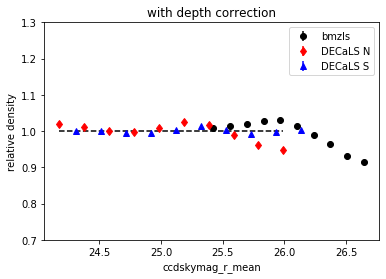

916
1446.187270174255
47256516 47256516
gal done
ran done


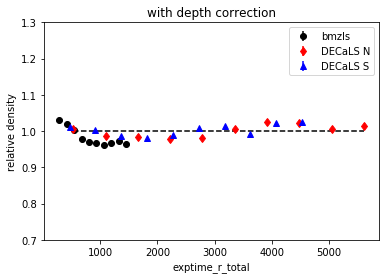

916
1.296672437723619
47256516 47256516
gal done
ran done


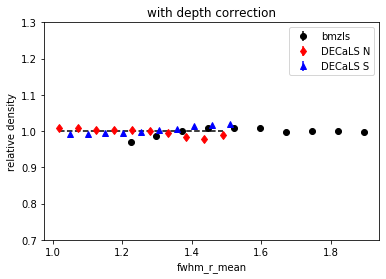

916
1.0
47256516 47256516
gal done
ran done


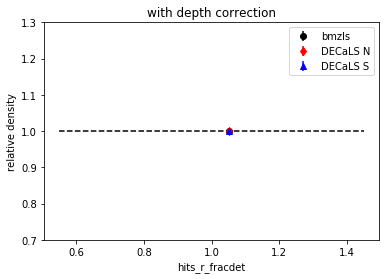

916
13.428957107865047
47256516 47256516
gal done
ran done


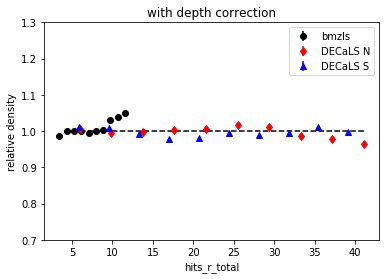

916
24.262318497543955
47256516 47256516
gal done
ran done


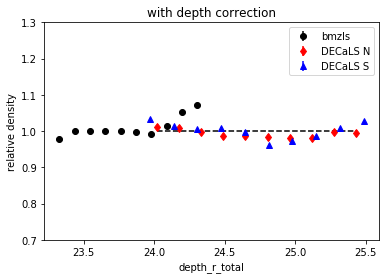

916
57359.53387586379
47256516 47256516
gal done
ran done


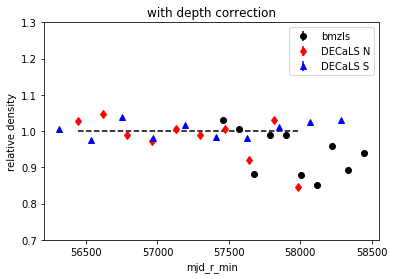

845
1.3991432063582103
47256516 47256516
gal done
ran done


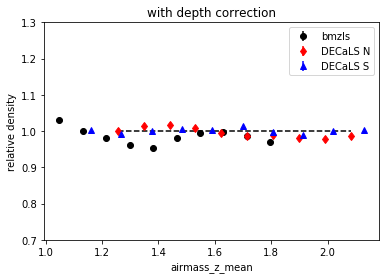

998
23.076823242050757
47256516 47256516
gal done
ran done


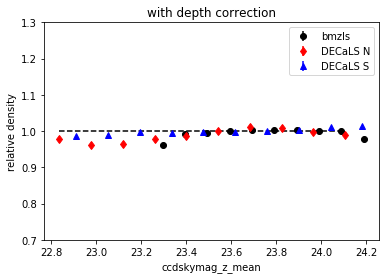

845
1917.0951113335057
47256516 47256516
gal done
ran done


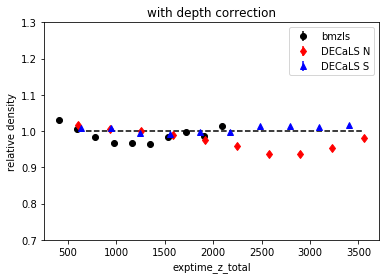

845
1.1221467816189927
47256516 47256516
gal done
ran done


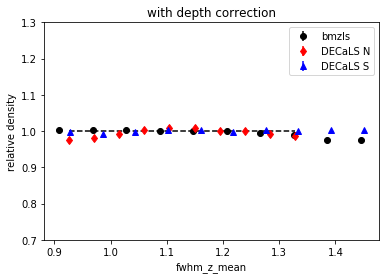

845
1.0
47256516 47256516
gal done
ran done


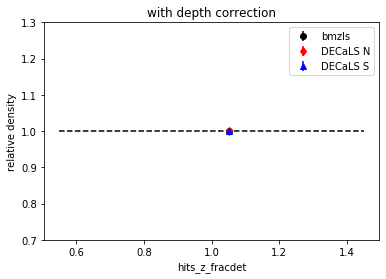

845
13.87963344237306
47256516 47256516
gal done
ran done


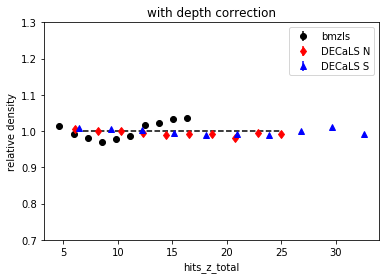

845
23.38037449501416
47256516 47256516
gal done
ran done


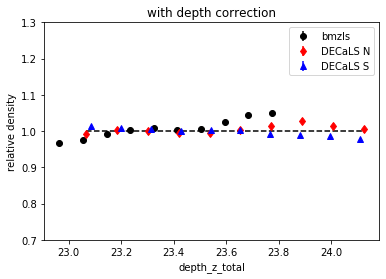

845
57229.14232635461
47256516 47256516
gal done
ran done


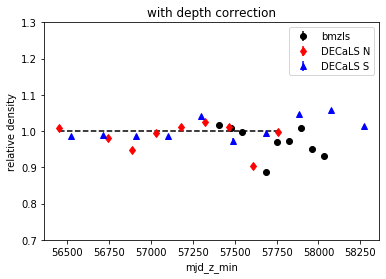

0
1405.9876000552176
47256516 47256516
gal done
ran done


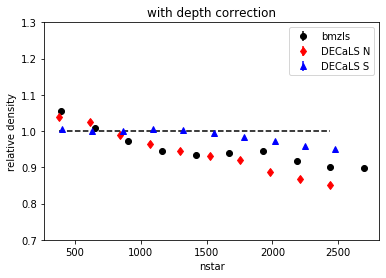

0
0.30985871034917145
47256516 47256516
gal done
ran done


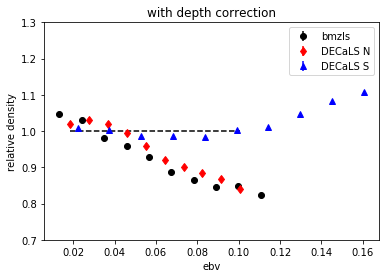

0
20.78052943080509
47256516 47256516
gal done
ran done


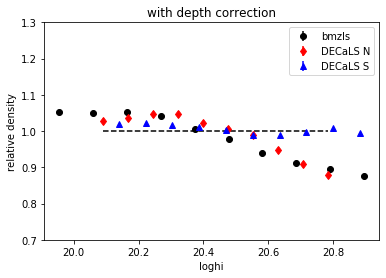

In [78]:
for name in sm.columns:
    doplotmmap(name)

In [79]:
#Galactic extinction
#bmzls
hg1 = np.histogram(felg[dbml]['EBV'],weights=1./1./effnorthl[dbml],range=(0,0.15))
hr1 = np.histogram(relg[rbml]['EBV'],bins=hg1[1])
#DECaLS N
hg2 = np.histogram(felg[ddnl]['EBV'],weights=1./effsouthl[ddnl]**2.,range=(0,0.15))
hr2 = np.histogram(relg[rdnl]['EBV'],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(felg[ddsl]['EBV'],weights=1./effsouthl[ddsl]**2.,range=(0,0.15))
hr3 = np.histogram(relg[rdsl]['EBV'],bins=hg3[1])

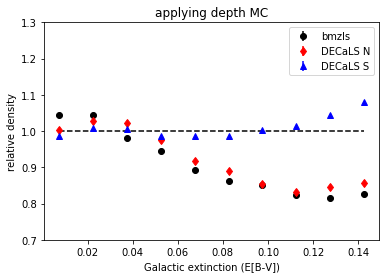

In [80]:
plotrel(hg1,hr1,hg2,hr2,hg3,hr3,'applying depth MC','Galactic extinction (E[B-V])')